In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import prettytensor as pt
import scipy.misc
import tensorflow as tf
# from scipy.misc import imsave
from tensorflow.examples.tutorials.mnist import input_data

import scipy

from deconv import deconv2d
from progressbar import ETA, Bar, Percentage, ProgressBar, DynamicMessage

from time import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.spatial import KDTree

from utils.Dataset import Dataset
from scipy.io import loadmat

from utils.Transform import PCA
from utils.Visualization import show_img,draw_grad
from utils.Model import save_model_params,restore_model_params

# sess = tf.InteractiveSession()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
flags = tf.flags
logging = tf.logging

flags.DEFINE_integer("batch_size", 128, "batch size")
flags.DEFINE_integer("updates_per_epoch", 1000, "number of updates per epoch")
flags.DEFINE_integer("max_epoch", 100, "max epoch")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
flags.DEFINE_string("working_directory", "", "")
flags.DEFINE_integer("hidden_size", 50, "size of the hidden VAE unit")
# flags.DEFINE_integer("hidden_size", 2, "size of the hidden VAE unit")

flags.DEFINE_float("lam", 10, "regularization parameter")
flags.DEFINE_integer("dim", 28*20, "dimensionality of the image")
flags.DEFINE_integer("tan_dim", 5, "dimensionality of the tagent space")
flags.DEFINE_float("sig",10.0,"kernel bandwidth parameter")


FLAGS = flags.FLAGS

In [3]:
def discriminator(input_tensor):
    '''Create discriminator network.

    Args:
        input_tensor: a batch of flattened images [batch_size, 28*28]

    Returns:
        A tensor that expresses the logit of being a true sample
    '''

    return (pt.wrap(input_tensor).
            reshape([FLAGS.batch_size, 28, 20, 1]).
            conv2d(5, 32, stride=2).
            conv2d(5, 64, stride=2).
            conv2d(5, 128, edges='VALID').
            dropout(0.9).
            flatten().
            fully_connected(1, activation_fn=None)).tensor

def generator(Z=None):
    '''Create a generator network
    
    '''
    if Z==None:
        Z = tf.random_uniform([FLAGS.batch_size,FLAGS.hidden_size])
    
    return (pt.wrap(Z).
            reshape([FLAGS.batch_size, 1, 1, FLAGS.hidden_size]).
            deconv2d([3,1], 128, edges='VALID').
            deconv2d(5, 64, edges='VALID').
            deconv2d(5, 32, stride=2).
            deconv2d(5, 1, stride=2, activation_fn=tf.nn.sigmoid).
            flatten()).tensor

def chi2_loss(Xn,Yn):
    C = tf.matmul(Xn,Yn,transpose_a=True)/(2*FLAGS.batch_size) # bias correction needed???
    chi2 = tf.reduce_sum(tf.square(C))
    return chi2

In [4]:
# Read data

filepath = 'datasets/frey/frey_rawface.mat'

frey_data = loadmat(filepath)

frey_full = np.reshape(frey_data['ff'].T,[-1,28,20])
frey_full = frey_full/255.

frey_data = Dataset(frey_full)

In [5]:
input_tensor = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.dim])
learning_rate = tf.placeholder(tf.float32)
# input_code = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.hidden_size])

# ema = tf.train.ExponentialMovingAverage(decay=0.99)
ema = tf.train.ExponentialMovingAverage(decay=0.8)

label = tf.constant(np.concatenate((np.ones([FLAGS.batch_size,1]),\
                    -np.ones([FLAGS.batch_size,1]))),dtype=tf.float32)

with tf.device('/gpu:2'):

    with pt.defaults_scope(activation_fn=tf.nn.elu,
                           batch_normalize=True,
                           learned_moments_update_rate=0.0003,
                           variance_epsilon=0.001,
                           scale_after_normalization=True):
        with pt.defaults_scope(phase=pt.Phase.train):
            with tf.variable_scope("discriminator") as scope:
                D_input = discriminator(input_tensor)
            with tf.variable_scope("generator") as scope:
                generated_tensor = generator()
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_generated = discriminator(generated_tensor)

        with pt.defaults_scope(phase=pt.Phase.test):
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_input_test = discriminator(input_tensor)
            with tf.variable_scope("generator", reuse=True) as scope:
                generated_tensor_test = generator()
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_generated_test = discriminator(generated_tensor)
                
#     D = tf.concat((D_input,D_generated),axis=0)
    D = tf.sigmoid(tf.concat((D_input,D_generated),axis=0))

    D_mean,D_var = tf.nn.moments(D,axes=[0])
    maintain_averages_op = ema.apply([D_mean, D_var])

    ema_D_mean = ema.average(D_mean)
    ema_D_std = tf.sqrt(ema.average(D_var))

    Dn = (D-ema_D_mean)/ema_D_std

    data_loss = tf.reduce_mean(D_input-tf.nn.softplus(D_input))
    sampl_loss = -tf.reduce_mean(tf.nn.softplus(D_generated))
    
    discr_loss = -(data_loss+sampl_loss)
    gener_loss = chi2_loss(Dn,label)
    
    discr_vars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('discriminator')]
    gener_vars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('generator')]

#     optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate, epsilon=1.0)
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1.0)
    
    train_gan_discr = pt.apply_optimizer(optimizer, losses=[discr_loss], var_list=discr_vars)
    train_gan_gener = pt.apply_optimizer(optimizer, losses=[gener_loss], var_list=gener_vars)

In [63]:
# Initialization

init = tf.global_variables_initializer()
sess.run(init)

In [74]:
lr_discr = 5e-4
lr_gener = 1e-3

max_epoch = 50
updates_per_epoch = 1000
# max_epoch = 10
# updates_per_epoch = 100
# max_epoch = 500
# updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        x,_ = frey_data.next_batch(FLAGS.batch_size)
        
        _,loss_val,_ = sess.run([train_gan_discr,discr_loss,maintain_averages_op],
                    {input_tensor: x, learning_rate: lr_discr})
        
        _,loss_val,_ = sess.run([train_gan_gener,gener_loss,maintain_averages_op], 
                    {input_tensor: x, learning_rate: lr_gener})
        
        loss_record[step] = loss_val
        
    t1 = time()
    
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)

_ = plt.plot(epoch_record)

[1, 0.85569792246818543, 25.915287971496582]
[2, 0.83438227313756941, 25.55750012397766]
[3, 0.83551620554924011, 25.49980092048645]
[4, 0.82852017593383787, 25.60572600364685]
[5, 0.84202145767211911, 25.731218814849854]
[6, 0.85044955343008044, 26.063472032546997]
[7, 0.86972561383247371, 25.70459294319153]
[8, 0.87904115653038029, 25.99653720855713]
[9, 0.90405492633581164, 25.52756690979004]
[10, 0.90883765661716465, 25.83845090866089]


KeyboardInterrupt: 

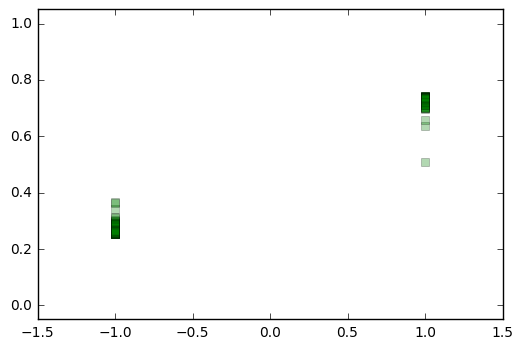

In [36]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# running_mean,running_std = sess.run([ema_D_mean,ema_D_std],{input_tensor: x})
# print([running_mean[0],running_std[0]])
Dn_val = sigmoid(sess.run(Dn,{input_tensor: x}))
# _ = plt.hist(Dn_val)
label_np = np.concatenate((np.ones([FLAGS.batch_size,1]),\
                    -np.ones([FLAGS.batch_size,1])))
_ = plt.plot(label_np,Dn_val,'sg',alpha=.3)
_ = plt.xlim([-1.5,1.5])
_ = plt.ylim([-.05,1.05])
# print(Dn_val)

# print(np.dot(Dn_val.T,label_np)/(2*FLAGS.batch_size))

# gener_loss_tf = sess.run(gener_loss,{input_tensor: x})
# print(gener_loss_tf)

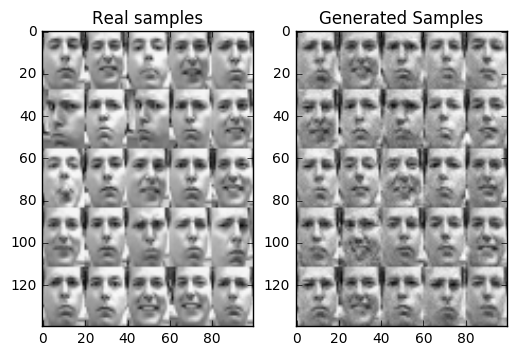

In [75]:
batch_idx = np.random.randint(np.shape(frey_full)[0],size=[FLAGS.batch_size,])

plt.subplot(1,2,1)
show_img(frey_full[batch_idx],M=5,size=[28,20])
_ = plt.title('Real samples')

plt.subplot(1,2,2)
x1 = sess.run(generated_tensor)
show_img(x1,M=5,size=[28,20])
_ = plt.title('Generated Samples')

plt.show()

In [ ]:
# Draw 10000 generated samples and compare with the original data

num_sampl = 10000
max_epoch = np.int(np.floor(num_sampl/FLAGS.batch_size))

frey_generated = np.zeros([num_sampl, FLAGS.dim])

for step in range(max_epoch+1):
    
    batch_idx = range(step*FLAGS.batch_size,np.min([(step+1)*FLAGS.batch_size,num_sampl]))

    x = sess.run(generated_tensor_test)
    
    frey_generated[batch_idx,:] = x[:np.size(batch_idx),:]

In [ ]:
latent_dim = 5

score,evals,coef,dmean = PCA(np.reshape(frey_full.copy(),[np.shape(frey_full)[0],FLAGS.dim]),latent_dim)

width = 6
height = 3
plt.figure(figsize=(width, height))

dim1 = 0
dim2 = 2

# Data distribution

plt.subplot(1,2,1)
# _ = plt.plot(score[:,0],score[:,1],'sg', alpha=.3)
_,_,_,_ = plt.hist2d(score[:,dim1],score[:,dim2],bins=20,normed=True,
                     range=[[-3,3],[-1.5,2.5]])
# _ = plt.axis('square')

score_generated = np.dot(frey_generated-dmean,coef)

plt.subplot(1,2,2)
# _ = plt.plot(score_generated[:,0],score_generated[:,1],'sg', alpha=.3)
_,_,_,_ = plt.hist2d(score_generated[:,dim1],score_generated[:,dim2],bins=20,normed=True,
                    range=[[-3,3],[-1.5,2.5]])
# _ = plt.axis('square')

# dim (0,2)